In [41]:
from __future__ import print_function
from builtins import input

import numpy as np

from sporco import util
from sporco import signal
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()
from sporco.cupy import (cupy_enabled, np2cp, cp2np, select_device_by_load,
                         gpu_info)
from sporco.cupy.admm import tvl1

In [42]:
img = util.ExampleImages().image('e.jpg', scaled=True,
                                 idxexp=np.s_[:,:])

In [43]:
np.random.seed(12345)
imgn = signal.spnoise(img, 0.44)

In [44]:
lmbda = 8e-1
opt = tvl1.TVL1Denoise.Options({'Verbose': True, 'MaxMainIter': 200,
                                'RelStopTol': 5e-3, 'gEvalY': False,
                                'AutoRho': {'Enabled': True}})

In [45]:
if not cupy_enabled():
    print('CuPy/GPU device not available: running without GPU acceleration\n')
else:
    id = select_device_by_load()
    info = gpu_info()
    if info:
        print('Running on GPU %d (%s)\n' % (id, info[id].name))

b = tvl1.TVL1Denoise(np2cp(imgn), lmbda, opt)
imgr = cp2np(b.solve())

CuPy/GPU device not available: running without GPU acceleration

Itn   Fnc       DFid      RegTV     r         s         ρ       
----------------------------------------------------------------
   0  3.47e+05  1.84e+05  2.04e+05  4.58e-01  1.18e+00  1.70e+00
   1  3.06e+05  1.94e+05  1.40e+05  3.42e-01  7.28e-01  1.70e+00
   2  3.02e+05  2.10e+05  1.15e+05  2.57e-01  5.03e-01  1.17e+00
   3  3.38e+05  2.66e+05  8.98e+04  3.06e-01  3.28e-01  8.34e-01
   4  3.64e+05  3.00e+05  7.88e+04  3.01e-01  2.36e-01  8.34e-01
   5  3.17e+05  2.76e+05  5.15e+04  2.28e-01  2.97e-01  9.42e-01
   6  2.57e+05  2.23e+05  4.20e+04  1.47e-01  2.59e-01  8.24e-01
   7  2.53e+05  2.20e+05  4.16e+04  1.73e-01  1.57e-01  6.20e-01
   8  2.62e+05  2.29e+05  4.08e+04  1.92e-01  9.71e-02  6.20e-01
   9  2.48e+05  2.25e+05  2.94e+04  1.49e-01  1.38e-01  8.73e-01
  10  2.27e+05  2.11e+05  2.09e+04  8.98e-02  1.43e-01  8.73e-01
  11  2.43e+05  2.24e+05  2.30e+04  9.65e-02  1.00e-01  6.91e-01
  12  2.61e+05  2.40e+05 

 124  3.02e+05  2.70e+05  4.03e+04  2.35e-01  5.61e-02  8.74e-01
 125  2.73e+05  2.50e+05  2.86e+04  1.70e-01  2.64e-01  1.79e+00
 126  2.18e+05  2.06e+05  1.50e+04  7.09e-02  2.77e-01  1.43e+00
 127  2.54e+05  2.26e+05  3.44e+04  2.27e-01  1.57e-01  7.25e-01
 128  2.67e+05  2.32e+05  4.48e+04  2.69e-01  5.95e-02  8.73e-01
 129  2.47e+05  2.23e+05  2.99e+04  1.50e-01  2.52e-01  1.86e+00
 130  2.17e+05  2.02e+05  1.89e+04  6.64e-02  2.47e-01  1.43e+00
 131  2.82e+05  2.55e+05  3.30e+04  2.10e-01  1.50e-01  7.41e-01
 132  3.08e+05  2.74e+05  4.21e+04  2.48e-01  6.02e-02  8.77e-01
 133  2.76e+05  2.53e+05  2.96e+04  1.79e-01  2.77e-01  1.78e+00
 134  2.18e+05  2.06e+05  1.54e+04  7.43e-02  2.89e-01  1.43e+00
 135  2.57e+05  2.28e+05  3.58e+04  2.40e-01  1.63e-01  7.23e-01
 136  2.71e+05  2.34e+05  4.66e+04  2.82e-01  6.43e-02  8.77e-01
 137  2.50e+05  2.25e+05  3.07e+04  1.56e-01  2.61e-01  1.84e+00
 138  2.17e+05  2.02e+05  1.94e+04  6.87e-02  2.55e-01  1.42e+00
 139  2.85e+05  2.58e+05 

In [46]:
print("TVL1Denoise solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % metric.psnr(img, imgn))
print("Denoised image PSNR: %5.2f dB" % metric.psnr(img, imgr))

TVL1Denoise solve time: 629.95 s
Noisy image PSNR:     7.35 dB
Denoised image PSNR: 16.25 dB


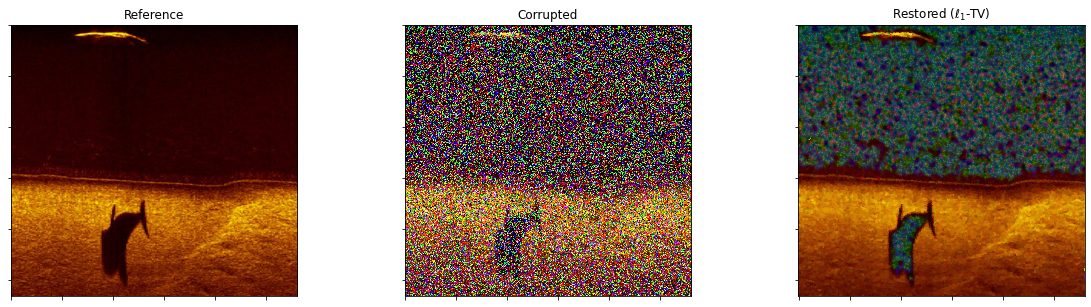

In [47]:
fig = plot.figure(figsize=(20, 5))
plot.subplot(1, 3, 1)
plot.imview(img, title='Reference', fig=fig)
plot.subplot(1, 3, 2)
plot.imview(imgn, title='Corrupted', fig=fig)
plot.subplot(1, 3, 3)
plot.imview(imgr, title=r'Restored ($\ell_1$-TV)', fig=fig)
fig.show()


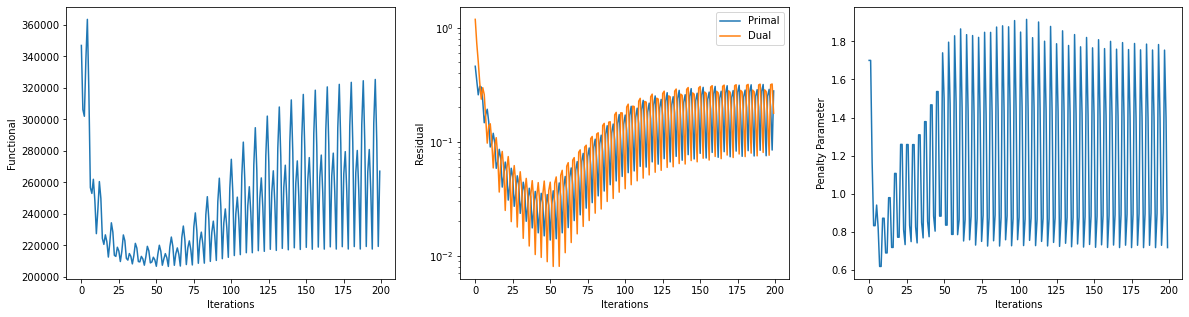

In [48]:
its = b.getitstat()
ObjFun = [float(x) for x in its.ObjFun]
PrimalRsdl = [float(x) for x in its.PrimalRsdl]
DualRsdl = [float(x) for x in its.DualRsdl]
fig = plot.figure(figsize=(20, 5))
plot.subplot(1, 3, 1)
plot.plot(ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(1, 3, 2)
plot.plot(np.vstack((PrimalRsdl, DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'], fig=fig)
plot.subplot(1, 3, 3)
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter', fig=fig)
fig.show()


In [49]:
from skimage.metrics import structural_similarity as ssim
ssim_const_1 = ssim(img, imgr,
                  data_range=imgr.max() - imgr.min(), multichannel=True)

print(ssim_const_1)#structure similarity between two random variables -it measures contrast,variance,mean, luminous,covariance 

0.41493476393705575
